# Visualizing Separation Analysis

**Gregory Way 2019**

Visualizing GTEx Sex and TARGET MYCN Status Features

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘cowplot’ was built under R version 3.4.4”

In [2]:
# Store t test results and identify top features
t_test_results_files <- list.files("results", full.names = TRUE)
t_test_results_files <- t_test_results_files[grepl('t_test', t_test_results_files)]
t_test_results_files

[1] "results/nbl_mycn_separation_target_t_test.tsv"
[2] "results/sex_separation_gtex_t_test.tsv"       
[3] "results/sex_separation_tcga_t_test.tsv"

In [3]:
# Store t test results and identify top features
best_result_list <- list()
line_gg_list <- list()
for (t_test_file in t_test_results_files) {
  full_results_df <- readr::read_tsv(t_test_file,
                                     col_types = readr::cols(
                                       t_stat = readr::col_double(),
                                       t_p = readr::col_double(),
                                       algorithm = readr::col_character(),
                                       feature_num = readr::col_double(),
                                       z_dim = readr::col_double(),
                                       signal = readr::col_character(),
                                       seed = readr::col_double(),
                                       neg_log_p = readr::col_double()
                                       )
                                     )
  
  top_results_df <- full_results_df %>%
    dplyr::group_by(algorithm, z_dim, signal) %>%
    dplyr::filter(neg_log_p == max(neg_log_p),
                  signal == "signal")
  
  # Create factors for plotting
  top_results_df$z_dim <-
    factor(top_results_df$z_dim,
           levels =
             sort(as.numeric(paste(unique(top_results_df$z_dim))))
    )
  
  top_results_df$algorithm <-
    factor(top_results_df$algorithm,
           levels = c("pca", "ica", "nmf", "dae", "vae"))
  
  panel_gg <- ggplot(top_results_df,
                       aes(x = z_dim,
                           y = neg_log_p,
                           color = algorithm,
                           group = algorithm)) +
    geom_smooth(aes(fill = algorithm),
                lwd = 0.3,
                alpha = 0.4,
                method = 'loess',
                formula = 'y ~ x') +
    geom_point(size = 0.5) +
    scale_color_manual(name = "Algorithm",
                       values = c("#e41a1c",
                                  "#377eb8",
                                  "#4daf4a",
                                  "#984ea3",
                                  "#ff7f00"),
                       labels = c("pca" = "PCA",
                                  "ica" = "ICA",
                                  "nmf" = "NMF",
                                  "dae" = "DAE",
                                  "vae" = "VAE")) +
    scale_fill_manual(name = "Algorithm",
                      values = c("#e41a1c",
                                 "#377eb8",
                                 "#4daf4a",
                                 "#984ea3",
                                 "#ff7f00"),
                      labels = c("pca" = "PCA",
                                 "ica" = "ICA",
                                 "nmf" = "NMF",
                                 "dae" = "DAE",
                                 "vae" = "VAE")) +
    theme_bw() +
    ylab("-log10 P Value") +
    xlab("k Dimensions") +
    theme(axis.title.x = element_text(size = 7),
          axis.title.y = element_text(size = 7),
          axis.text.x = element_text(angle = 90,
                                     size = 5),
          axis.text.y = element_text(size = 6),
          plot.title = element_text(size = 8,
                                    hjust = 0.5),
          legend.text = element_text(size = 5),
          legend.title = element_text(size = 6),
          legend.key.size = unit(0.4, "lines"))
  
  
  best_result_df <- top_results_df %>%
    dplyr::arrange(desc(neg_log_p)) %>%
    dplyr::ungroup() %>%
    dplyr::top_n(n = 1, wt = neg_log_p)
  
  best_result_list[[t_test_file]] <- best_result_df
  line_gg_list[[t_test_file]] <- panel_gg
}

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

## Plot GTEx Sex Example

In [4]:
file <- file.path("..", "0.expression-download", "download", "GTEx_v7_Annotations_SubjectPhenotypesDS.txt")
gtex_sex_df <- readr::read_tsv(file)
head(gtex_sex_df, 2)

Parsed with column specification:
cols(
  SUBJID = col_character(),
  SEX = col_double(),
  AGE = col_character(),
  DTHHRDY = col_double()
)


SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F,2,60-69,4
GTEX-111CU,1,50-59,0


In [5]:
file <- file.path("..", "0.expression-download", "download", "GTEx_v7_Annotations_SampleAttributesDS.txt")
gtex_pheno_df <- readr::read_tsv(file, col_types = readr::cols(.default = readr::col_character(),
                                                               "SMGTC" = readr::col_character()))

full_gtex_ids <- c()
for (gtex_id in strsplit(gtex_pheno_df$SAMPID, "-")) {
  gtex_id_unlist <- unlist(gtex_id)
  sample_id <- paste0(gtex_id_unlist[1], "-", gtex_id_unlist[2])
  full_gtex_ids <- c(full_gtex_ids, sample_id)
}

gtex_pheno_df$SUBJID <- full_gtex_ids
gtex_pheno_df <- gtex_pheno_df %>%
    dplyr::left_join(gtex_sex_df, by = "SUBJID")

head(gtex_pheno_df, 2)

SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,⋯,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-0003-SM-58Q7G,NA,B1,NA,NA,Blood,Whole Blood,0013756,1188.0,NA,⋯,NA,NA,NA,NA,NA,NA,GTEX-1117F,2,60-69,4
GTEX-1117F-0003-SM-5DWSB,NA,B1,NA,NA,Blood,Whole Blood,0013756,1188.0,NA,⋯,NA,NA,NA,NA,NA,NA,GTEX-1117F,2,60-69,4


In [6]:
best_gtex_k_dim <- paste(best_result_list[[t_test_results_files[2]]]$z_dim[1])
best_gtex_seed <- paste(best_result_list[[t_test_results_files[2]]]$seed[1])
best_gtex_feature <- paste0(paste(best_result_list[[t_test_results_files[2]]]$algorithm[1]),
                            "_", 
                            paste(best_result_list[[t_test_results_files[2]]]$feature_num[1]))

In [7]:
print(best_gtex_k_dim)
print(best_gtex_seed)
print(best_gtex_feature)

[1] "200"
[1] "451283"
[1] "nmf_111"


In [8]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "GTEX_results",
                          "ensemble_z_matrices",
                          paste0("gtex_components_", best_gtex_k_dim),
                          paste0("model_", best_gtex_seed, "_z_test_matrix.tsv.gz"))

top_gtex_feature_df <- readr::read_tsv(feature_file,
                                       col_types = readr::cols(
                                           .default = readr::col_double(),
                                           sample_id = readr::col_character()
                                       )
                                      ) %>%
    dplyr::select(sample_id, !!best_gtex_feature)

head(top_gtex_feature_df)

sample_id,nmf_111
GTEX-ZTX8-1126-SM-51MRM,0.0000000
GTEX-Y3IK-2426-SM-4WWDU,0.0000000
GTEX-X62O-0826-SM-46MW8,0.3224531
GTEX-13O3O-0011-R5b-SM-5KM44,0.0000000
GTEX-X15G-1926-SM-4PQZQ,0.0000000
GTEX-13OVJ-0011-R7a-SM-5L3G1,0.0000000


In [9]:
balance_file <- file.path("results", "balanced_gtex_tissues.tsv")
balanced_gtex_tissues <- readr::read_tsv(balance_file, col_types = readr::cols()) %>%
    dplyr::pull(SMTS)

balanced_gtex_tissues

[1] "Adrenal Gland" "Blood Vessel"  "Brain"         "Breast"       
 [5] "Colon"         "Esophagus"     "Heart"         "Lung"         
 [9] "Muscle"        "Pancreas"      "Skin"          "Spleen"       
[13] "Stomach"

In [10]:
top_gtex_feature_df <- top_gtex_feature_df %>%
    dplyr::left_join(gtex_pheno_df, by = c("sample_id" = "SAMPID")) %>%
    dplyr::filter(SMTS %in% balanced_gtex_tissues)

top_gtex_feature_df$SEX <- dplyr::recode_factor(top_gtex_feature_df$SEX, `1` = "Male", `2` = "Female")
top_gtex_feature_df$SEX <- factor(top_gtex_feature_df$SEX, levels = c("Female", "Male"))

In [11]:
male_scores <- top_gtex_feature_df %>%
    dplyr::filter(SEX == "Male") %>%
    dplyr::pull(!!best_gtex_feature)
female_scores <- top_gtex_feature_df %>%
    dplyr::filter(SEX == "Female") %>%
    dplyr::pull(!!best_gtex_feature)

gtex_ttest_result <- t.test(male_scores, female_scores, var.equal = FALSE, paired = FALSE)
gtex_ttest_result


	Welch Two Sample t-test

data:  male_scores and female_scores
t = 44.507, df = 499.01, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3461038 0.3780718
sample estimates:
   mean of x    mean of y 
3.621372e-01 4.940517e-05 


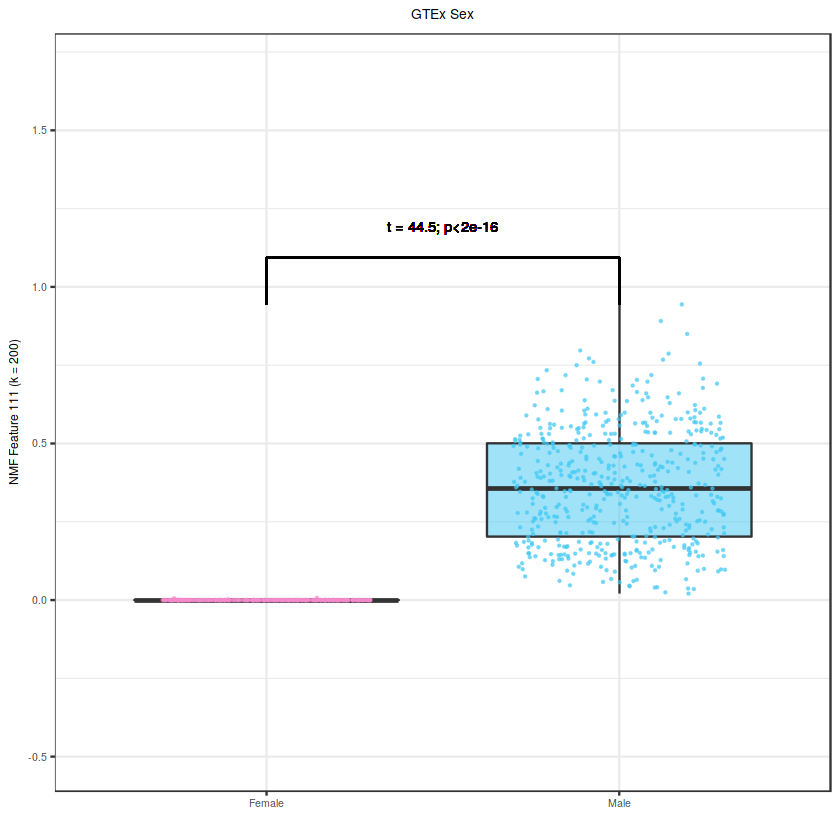

In [12]:
gtex_sex_gg <- ggplot(top_gtex_feature_df,
                      aes_string(y = best_gtex_feature,
                                 x = "SEX",
                                 fill = "SEX")) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = SEX),
              size = 0.2,
              alpha = 0.6,
              width = 0.3) +
  scale_fill_manual(labels = c("Male" = "Male",
                               "Female" = "Female"),
                    values = c("Male" = "#42c8f4",
                               "Female" = "#f489c9")) +
  scale_color_manual(labels = c("Male" = "Male",
                                "Female" = "Female"),
                     values = c("Male" = "#42c8f4",
                                "Female" = "#f489c9")) +
  theme_bw() +
  ylab("NMF Feature 111 (k = 200)") +
  xlab("") +
  ylim(c(-0.5, 1.7)) +
  ggtitle("GTEx Sex") +
  theme(axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        plot.title = element_text(size = 8,
                                  hjust = 0.5),
        legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(top_gtex_feature_df[, best_gtex_feature]) + 0.15,
                     xend=2,
                     yend=max(top_gtex_feature_df[, best_gtex_feature]) + 0.15),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(top_gtex_feature_df[, best_gtex_feature]) + 0.15,
                     xend=1,
                     yend=max(top_gtex_feature_df[, best_gtex_feature])),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(top_gtex_feature_df[, best_gtex_feature]) + 0.15,
                     xend=2,
                     yend=max(top_gtex_feature_df[, best_gtex_feature])),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(top_gtex_feature_df[, best_gtex_feature]) + 0.25),
              size = 3.0,
              label = paste0("t = ",
                            round(gtex_ttest_result$statistic, 1),
                            "; p",
                            format.pval(gtex_ttest_result$p.value, digits = 2)))

gtex_sex_gg

## Plot TCGA Sex Example

In [13]:
# Load TCGA phenotype data
file <- file.path("..", "0.expression-download", "download", "TCGA-CDR-SupplementalTableS1.xlsx")
tcga_pheno_df <- readxl::read_xlsx(file, sheet=1, col_types = "text")

print(dim(tcga_pheno_df))
head(tcga_pheno_df)

New names:
* `` -> `..1`


[1] 11160    34


..1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,⋯,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
1,TCGA-OR-A5J1,ACC,58,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,1355,1,1355,1,754,1,754,NA
2,TCGA-OR-A5J2,ACC,44,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,1677,1,1677,NA,NA,1,289,NA
3,TCGA-OR-A5J3,ACC,23,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,0,2091,0,2091,1,53,1,53,NA
4,TCGA-OR-A5J4,ACC,23,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,423,1,423,NA,NA,1,126,NA
5,TCGA-OR-A5J5,ACC,30,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,1,365,1,365,NA,NA,1,50,NA
6,TCGA-OR-A5J6,ACC,29,FEMALE,BLACK OR AFRICAN AMERICAN,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],⋯,NA,0,2703,0,2703,0,2703,0,2703,NA


In [14]:
best_tcga_k_dim <- paste(best_result_list[[t_test_results_files[3]]]$z_dim)
best_tcga_seed <- paste(best_result_list[[t_test_results_files[3]]]$seed)
best_tcga_feature <- paste0(paste(best_result_list[[t_test_results_files[3]]]$algorithm),
                            "_", 
                            paste(best_result_list[[t_test_results_files[3]]]$feature_num))

In [15]:
print(best_tcga_k_dim)
print(best_tcga_seed)
print(best_tcga_feature)

[1] "90"
[1] "165158"
[1] "ica_53"


In [16]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TCGA_results",
                          "ensemble_z_matrices",
                          paste0("tcga_components_", best_tcga_k_dim),
                          paste0("model_", best_tcga_seed, "_z_test_matrix.tsv.gz"))

top_tcga_feature_df <- readr::read_tsv(feature_file,
                                       col_types = readr::cols(
                                           .default = readr::col_double(),
                                           sample_id = readr::col_character()
                                       )
) %>%
  dplyr::select(sample_id, !!best_tcga_feature)

head(top_tcga_feature_df)

sample_id,ica_53
TCGA-CN-5365-01,-0.008143607
TCGA-LP-A7HU-01,-0.016654754
TCGA-22-5491-11,0.004007585
TCGA-CS-6667-01,0.001055000
TCGA-20-1684-01,0.047395277
TCGA-AK-3453-01,0.029171493


In [17]:
balance_file <- file.path("results", "balanced_tcga_tissues.tsv")
balanced_tcga_tissues <- readr::read_tsv(balance_file, col_types = readr::cols()) %>%
    dplyr::pull(type)

balanced_tcga_tissues

[1] "COAD" "DLBC" "GBM"  "HNSC" "KICH" "KIRC" "KIRP" "LAML" "LGG"  "LUAD"
[11] "PCPG" "READ" "SARC" "SKCM" "THYM" "UVM"

In [18]:
full_tcga_ids <- c()
for (tcga_id in strsplit(top_tcga_feature_df$sample_id, "-")) {
  tcga_id_unlist <- unlist(tcga_id)
  sample_id <- paste0(tcga_id_unlist[1], "-", tcga_id_unlist[2], "-", tcga_id_unlist[3])
  full_tcga_ids <- c(full_tcga_ids, sample_id)
}

top_tcga_feature_df$tcga_id <- full_tcga_ids
top_tcga_feature_df <- top_tcga_feature_df %>%
  dplyr::left_join(tcga_pheno_df, by = c("tcga_id" = "bcr_patient_barcode"))

top_tcga_feature_df$gender[is.na(top_tcga_feature_df$gender)] <- "Unlabeled"
top_tcga_feature_df$gender <- dplyr::recode_factor(top_tcga_feature_df$gender,
                                                   "MALE" = "Male",
                                                   "FEMALE" = "Female")
top_tcga_feature_df$gender <- factor(top_tcga_feature_df$gender,
                                     levels = c("Female", "Male", "Unlabeled"))

top_tcga_feature_df <- top_tcga_feature_df %>%
    dplyr::filter(type %in% balanced_tcga_tissues)

head(top_tcga_feature_df, 3)

sample_id,ica_53,tcga_id,..1,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,⋯,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
TCGA-CN-5365-01,-0.008143607,TCGA-CN-5365,3329,HNSC,38,Male,WHITE,Stage IVB,Stage IVC,⋯,NA,1,351,1,351,NA,NA,1,351,NA
TCGA-CS-6667-01,0.001055000,TCGA-CS-6667,4927,LGG,39,Female,WHITE,[Not Available],[Not Available],⋯,NA,0,1469,0,1469,NA,NA,0,1469,NA
TCGA-AK-3453-01,0.029171493,TCGA-AK-3453,3954,KIRC,58,Female,WHITE,Stage II,[Not Applicable],⋯,NA,0,2531,0,2531,0,2531,0,2531,NA


In [19]:
male_scores <- top_tcga_feature_df %>%
    dplyr::filter(gender == "Male") %>%
    dplyr::pull(!!best_tcga_feature)
female_scores <- top_tcga_feature_df %>%
    dplyr::filter(gender == "Female") %>%
    dplyr::pull(!!best_tcga_feature)

tcga_ttest_result <- t.test(male_scores, female_scores, var.equal = FALSE, paired = FALSE)
tcga_ttest_result


	Welch Two Sample t-test

data:  male_scores and female_scores
t = 4.8641, df = 451.8, p-value = 1.591e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.003762159 0.008863171
sample estimates:
   mean of x    mean of y 
 0.001153948 -0.005158717 


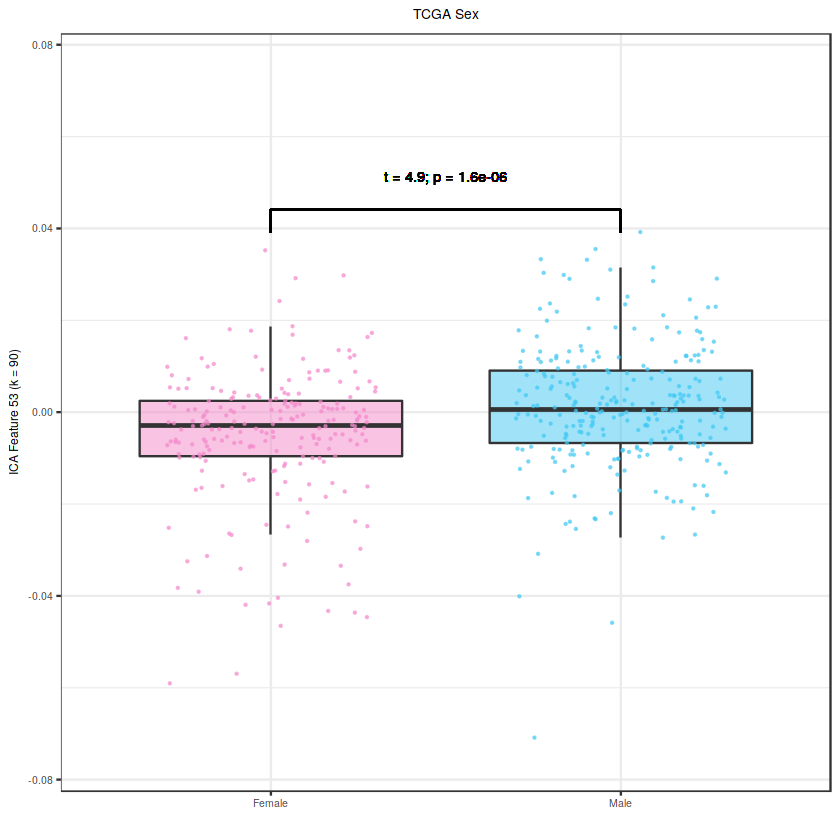

In [20]:
tcga_sex_gg <- ggplot(top_tcga_feature_df,
                      aes_string(y = best_tcga_feature,
                                 x = "gender",
                                 fill = "gender")) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = gender),
              size = 0.2,
              alpha = 0.6,
              width = 0.3) +
  scale_fill_manual(labels = c("Male" = "Male",
                               "Female" = "Female",
                               "Unlabeled" = "Unlabeled"),
                    values = c("Male" = "#42c8f4",
                               "Female" = "#f489c9",
                               "Unlabeled" = "grey25")) +
  scale_color_manual(labels = c("Male" = "Male",
                                "Female" = "Female",
                                "Unlabeled" = "Unlabeled"),
                     values = c("Male" = "#42c8f4",
                                "Female" = "#f489c9",
                                "Unlabeled" = "grey25")) +
  theme_bw() +
  ylim(c(-0.075, 0.075)) +
  ylab("ICA Feature 53 (k = 90)") +
  xlab("") +
  ggtitle("TCGA Sex") +
  theme(axis.title.x = element_text(size = 7),
        axis.title.y = element_text(size = 7),
        axis.text.x = element_text(size = 6),
        axis.text.y = element_text(size = 6),
        plot.title = element_text(size = 8,
                                  hjust = 0.5),
        legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(top_tcga_feature_df[, best_tcga_feature]) + 0.005,
                     xend=2,
                     yend=max(top_tcga_feature_df[, best_tcga_feature]) + 0.005),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(top_tcga_feature_df[, best_tcga_feature]) + 0.005,
                     xend=1,
                     yend=max(top_tcga_feature_df[, best_tcga_feature])),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(top_tcga_feature_df[, best_tcga_feature]) + 0.005,
                     xend=2,
                     yend=max(top_tcga_feature_df[, best_tcga_feature])),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(top_tcga_feature_df[, best_tcga_feature]) + 0.012),
              size = 3.0,
              label = paste0("t = ",
                            round(tcga_ttest_result$statistic, 1),
                            "; p = ",
                            format.pval(tcga_ttest_result$p.value, digits = 2)))

tcga_sex_gg

## Plot TARGET MYCN Amplification Results

In [21]:
best_target_k_dim <- paste(best_result_list[[t_test_results_files[1]]]$z_dim)
best_target_seed <- paste(best_result_list[[t_test_results_files[1]]]$seed)
best_target_feature <- paste0(paste(best_result_list[[t_test_results_files[1]]]$algorithm),
                              "_",
                              paste(best_result_list[[t_test_results_files[1]]]$feature_num))

In [22]:
print(best_target_k_dim)
print(best_target_seed)
print(best_target_feature)

[1] "50"
[1] "451283"
[1] "vae_12"


In [23]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TARGET_results",
                          "ensemble_z_matrices",
                          paste0("target_components_", best_target_k_dim),
                          paste0("model_", best_target_seed, "_z_matrix.tsv.gz"))

top_mycn_feature_df <- readr::read_tsv(feature_file,
                                       col_types = readr::cols(
                                           .default = readr::col_double(),
                                           sample_id = readr::col_character()
                                       )
                                      ) %>%
  dplyr::select(sample_id, !!best_target_feature)

In [24]:
# Load TARGET phenotype data
file <- file.path("..", "0.expression-download", "data", "2017-09-30-TARGET update harmonized.txt")
nbl_pheno_df <- readr::read_tsv(file)

full_target_ids <- c()
for (target_id in strsplit(top_mycn_feature_df$sample_id, "-")) {
  target_id_unlist <- unlist(target_id)
  full_target_ids <- c(full_target_ids, target_id_unlist[3])
}

top_mycn_feature_df$target_id <- full_target_ids
top_mycn_feature_df <- top_mycn_feature_df %>% 
  dplyr::inner_join(nbl_pheno_df, by = c("target_id" = "usi")) %>%
    dplyr::rename("mycn_status" = "MYCN status")

head(top_mycn_feature_df, 2)

Parsed with column specification:
cols(
  .default = col_character(),
  `Age at Diagnosis in Days` = col_double(),
  `Event Free Survival Time in Days` = col_double(),
  `Overall Survival Time in Days` = col_double(),
  `Year of Diagnosis` = col_double(),
  `Year of Last Follow Up` = col_double(),
  `Ploidy Value` = col_double()
)
See spec(...) for full column specifications.


sample_id,vae_12,target_id,Gender,Race,Ethnicity,Age at Diagnosis in Days,First Event,Event Free Survival Time in Days,Vital Status,⋯,Histology,Grade,MKI,Diagnostic Category,ICDO,ICDO Description,COG Risk Group,Site Relapse,Comment,target_update
TARGET-30-PARSBI-01,2.575049,PARSBI,Female,White,Not Hispanic or Latino,2390,Relapse,1377,Dead,⋯,Unfavorable,Undifferentiated or Poorly Differentiated,Low,Neuroblastoma,C76.2,"Abdomen, NOS Abdominal wall, NOS Intra-abdominal site, NOS",High Risk,Other metastatic sites,NA,old
TARGET-30-PATBMM-01,3.673986,PATBMM,Male,White,Not Hispanic or Latino,1112,Relapse,653,Alive,⋯,Unfavorable,Undifferentiated or Poorly Differentiated,Low,"Ganglioneuroblastoma, nodular",C74.9,"Adrenal gland, NOS Suprarenal gland Adrenal, NOS",High Risk,Bone,NA,old


In [25]:
amp_scores <- top_mycn_feature_df %>%
    dplyr::filter(mycn_status == "Amplified") %>%
    dplyr::pull(!!best_target_feature)
noamp_scores <- top_mycn_feature_df %>%
    dplyr::filter(mycn_status == "Not Amplified") %>%
    dplyr::pull(!!best_target_feature)

mycn_ttest_result <- t.test(amp_scores, noamp_scores, var.equal = FALSE, paired = FALSE)
mycn_ttest_result


	Welch Two Sample t-test

data:  amp_scores and noamp_scores
t = -13.051, df = 61.99, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.786899 -2.780917
sample estimates:
mean of x mean of y 
0.4818781 3.7657864 


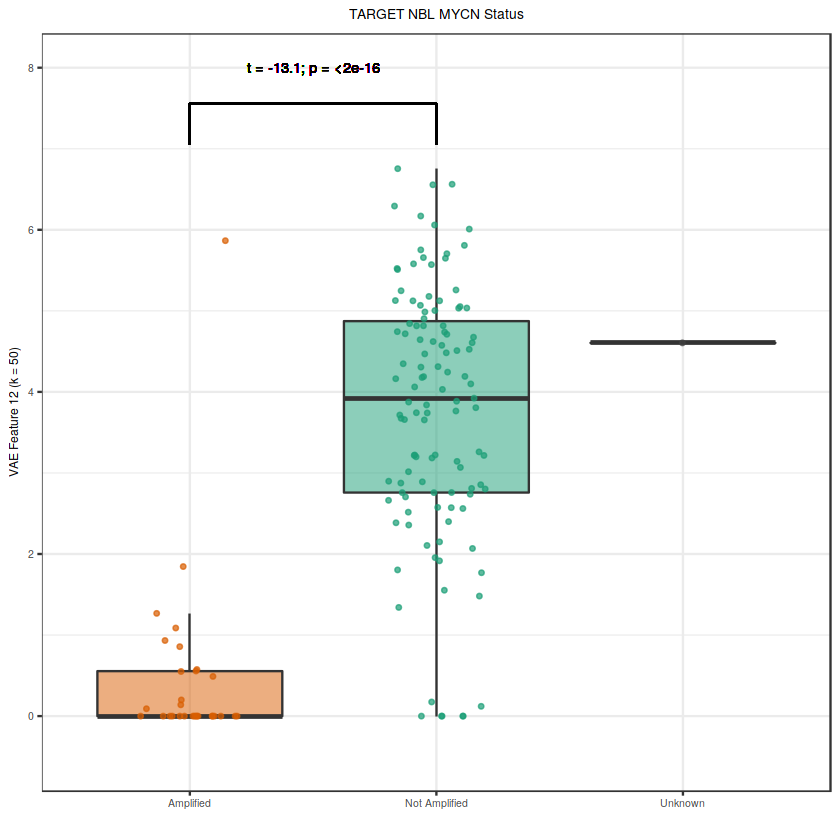

In [26]:
mycn_amp_gg <- ggplot(top_mycn_feature_df,
                      aes_string(y = best_target_feature,
                                 x = "mycn_status",
                                 fill = "mycn_status")) +
    geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
    geom_jitter(aes(color = mycn_status),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
    scale_fill_manual(labels = c("Amplified" = "Amplified",
                                 "Not Amplified" = "Not Amplified",
                                 "Unknown" = "Unknown"),
                    values = c("Amplified" = "#d95f02",
                               "Not Amplified" = "#1b9e77",
                               "Unknown" = "grey25")) +
    scale_color_manual(labels = c("Amplified" = "Amplified",
                                "Not Amplified" = "Not Amplified",
                                "Unknown" = "Unknown"),
                     values = c("Amplified" = "#d95f02",
                                "Not Amplified" = "#1b9e77",
                                "Unknown" = "grey25")) +
    theme_bw() +
    ylab("VAE Feature 12 (k = 50)") +
    xlab("") +
    ggtitle("TARGET NBL MYCN Status") +
    ylim(c(-0.5, 8.0)) +
    theme(axis.title.x = element_text(size = 7),
       axis.title.y = element_text(size = 7),
       axis.text.x = element_text(size = 6),
       axis.text.y = element_text(size = 6),
       plot.title = element_text(size = 8,
                                 hjust = 0.5),
       legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(top_mycn_feature_df[, best_target_feature]) + 0.8,
                     xend=2,
                     yend=max(top_mycn_feature_df[, best_target_feature]) + 0.8),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(top_mycn_feature_df[, best_target_feature]) + 0.8,
                     xend=1,
                     yend=max(top_mycn_feature_df[, best_target_feature]) + 0.3),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(top_mycn_feature_df[, best_target_feature]) + 0.8,
                     xend=2,
                     yend=max(top_mycn_feature_df[, best_target_feature]) + 0.3),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(top_mycn_feature_df[, best_target_feature]) + 1.25),
              size = 3.0,
              label = paste0("t = ",
                            round(mycn_ttest_result$statistic, 1),
                            "; p = ",
                            format.pval(mycn_ttest_result$p.value, digits = 2)))

mycn_amp_gg

## Plot MYCN Signature Applied to NBL Cell Lines

In [27]:
file <- file.path("results", "mycn_nbl_scores.tsv")
mycn_validation_df <- readr::read_tsv(file) %>%
    dplyr::rename("mycn_status" = "MYCN status")

mycn_validation_df$mycn_status <- dplyr::recode_factor(mycn_validation_df$mycn_status,
                                                       "Non-amplified" = "Not Amplified")
mycn_validation_df$mycn_status <- factor(mycn_validation_df$mycn_status,
                                         levels = c("Amplified", "Not Amplified"))
head(mycn_validation_df)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  vae_12 = col_double(),
  `Cell Line` = col_character(),
  `MYCN status` = col_character(),
  `1p36 del` = col_character(),
  `3p26 del` = col_character(),
  `11q23 del` = col_character(),
  `17q21-qter unbal gain` = col_character(),
  `ALK mutation` = col_character(),
  `p53 mutation` = col_character()
)


X1,vae_12,Cell Line,mycn_status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,27.22712,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22-pter,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,25.43260,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,22.03650,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,24.63928,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,23.80450,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
5,26.21906,COGN496,Amplified,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [28]:
amp_scores <- mycn_validation_df %>%
    dplyr::filter(mycn_status == "Amplified") %>%
    dplyr::pull(!!best_target_feature)
noamp_scores <- mycn_validation_df %>%
    dplyr::filter(mycn_status == "Not Amplified") %>%
    dplyr::pull(!!best_target_feature)

mycn_val_ttest_result <- t.test(amp_scores, noamp_scores, var.equal = FALSE, paired = FALSE)
mycn_val_ttest_result


	Welch Two Sample t-test

data:  amp_scores and noamp_scores
t = -3.1652, df = 23.192, p-value = 0.004294
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -10.044977  -2.106709
sample estimates:
mean of x mean of y 
 22.58503  28.66088 


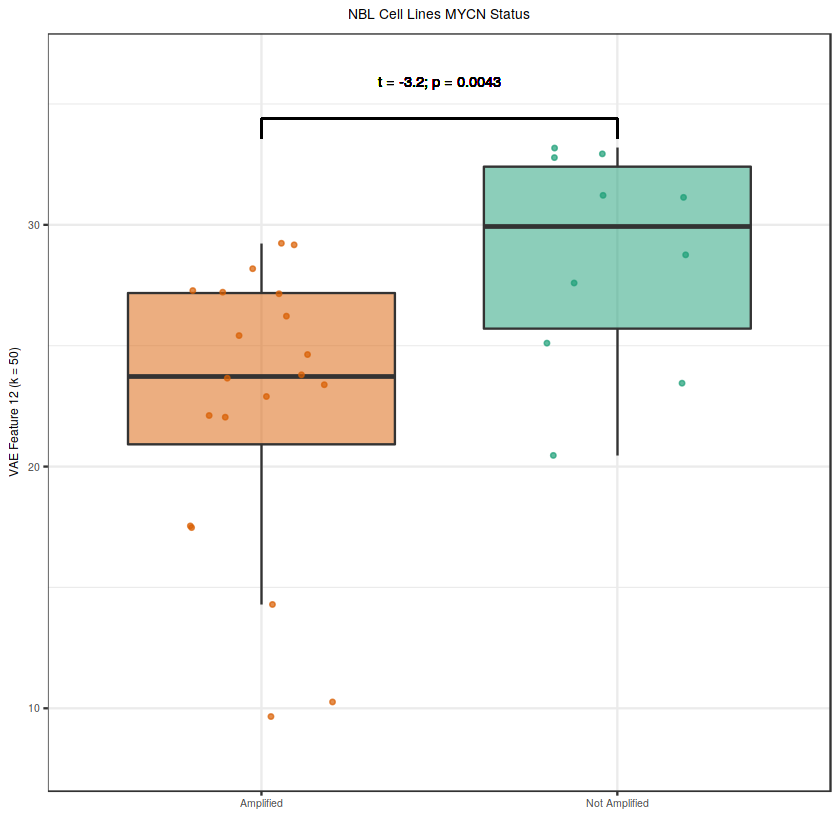

In [29]:
mycn_validation_gg <-
    ggplot(mycn_validation_df,
           aes_string(y = best_target_feature,
                      x = "mycn_status",
                      fill = "mycn_status")) +
    geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
    geom_jitter(aes(color = mycn_status),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
    theme_bw() +
    scale_fill_manual(labels = c("Amplified" = "Amplified",
                               "Not Amplified" = "Not Amplified"),
                    values = c("Amplified" = "#d95f02",
                               "Not Amplified" = "#1b9e77")) +
    scale_color_manual(labels = c("Amplified" = "Amplified",
                                "Not Amplified" = "Not Amplified"),
                     values = c("Amplified" = "#d95f02",
                                "Not Amplified" = "#1b9e77")) +
    ylab("VAE Feature 12 (k = 50)") +
    xlab("") +
    ggtitle("NBL Cell Lines MYCN Status") +
    ylim(c(8, 36.5)) +
    theme(axis.title.x = element_text(size = 7),
       axis.title.y = element_text(size = 7),
       axis.text.x = element_text(size = 6),
       axis.text.y = element_text(size = 6),
       plot.title = element_text(size = 8,
                                 hjust = 0.5),
       legend.position = "none") +
    geom_segment(aes(x=1,
                     y=max(mycn_validation_df[, best_target_feature]) + 1.2,
                     xend=2,
                     yend=max(mycn_validation_df[, best_target_feature]) + 1.2),
                 size=0.4) +
    geom_segment(aes(x=1,
                     y=max(mycn_validation_df[, best_target_feature]) + 1.2,
                     xend=1,
                     yend=max(mycn_validation_df[, best_target_feature]) + 0.4),
                 size=0.4) +
    geom_segment(aes(x=2,
                     y=max(mycn_validation_df[, best_target_feature]) + 1.2,
                     xend=2,
                     yend=max(mycn_validation_df[, best_target_feature]) + 0.4),
                 size=0.4) +
    geom_text(x=1.5,
              y = (max(mycn_validation_df[, best_target_feature]) + 2.75),
              size = 3.0,
              label = paste0("t = ",
                            round(mycn_val_ttest_result$statistic, 1),
                            "; p = ",
                            format.pval(mycn_val_ttest_result$p.value, digits = 2)))

mycn_validation_gg

## Compile Plot

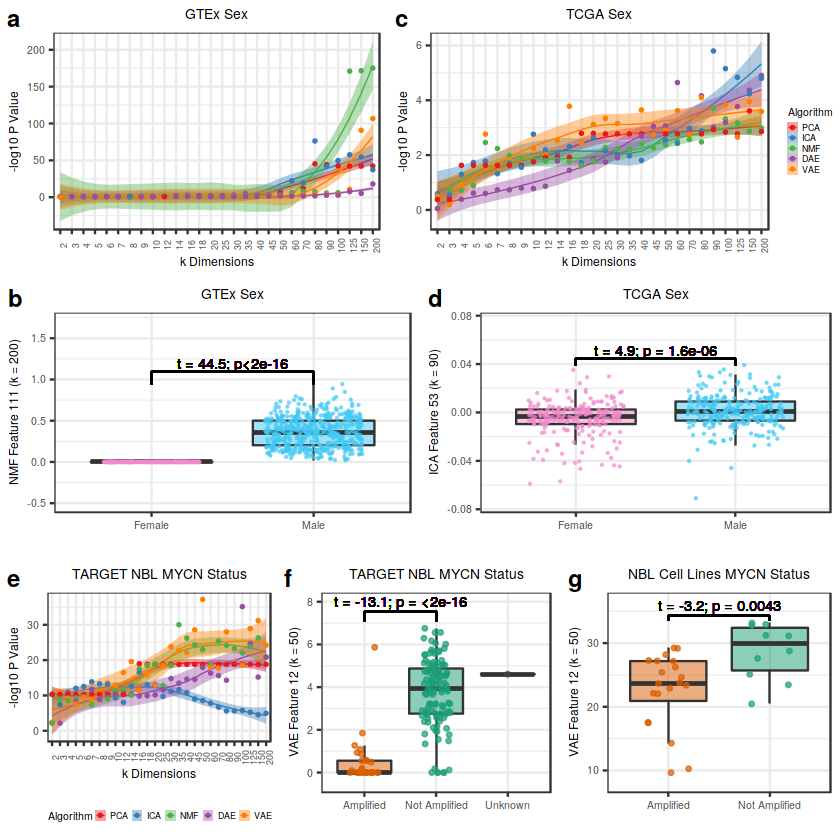

In [30]:
# Plot multi panel figure
line_gg_legend <- cowplot::get_legend(line_gg_list[[1]])

full_line_gg <- cowplot::plot_grid(
    line_gg_list[[2]] +
        theme(legend.position = "none") +
    ggtitle("GTEx Sex"),
        line_gg_list[[3]] +
    theme(legend.position = "none") +
        ggtitle("TCGA Sex"),
    labels = c("a", "c")
)

full_line_gg <- cowplot::plot_grid(full_line_gg,
                                   line_gg_legend,
                                   rel_widths = c(1, 0.08),
                                   ncol = 2)

box_gg <- cowplot::plot_grid(
    gtex_sex_gg,
    tcga_sex_gg,
    labels = c("b", "d"),
    ncol = 2
)


full_nbl_gg <- cowplot::plot_grid(
    line_gg_list[[1]] +
        ggtitle("TARGET NBL MYCN Status") +
        theme(legend.position = "bottom"),
    mycn_amp_gg +
        ggtitle("TARGET NBL MYCN Status"),
    mycn_validation_gg +
        ggtitle("NBL Cell Lines MYCN Status"),
    labels = c("e", "f", "g"),
    ncol = 3
)


main_plot <- cowplot::plot_grid(
    full_line_gg,
    box_gg,
    full_nbl_gg,
    nrow = 3
)

main_plot

In [31]:
for(extension in c('.png', '.pdf')) {
  fig_file <- paste0("full_separation_plot", extension)
  fig_file <- file.path("figures", fig_file)
  cowplot::save_plot(filename = fig_file,
                     plot = main_plot,
                     base_height = 180,
                     base_width = 170,
                     units = "mm")
}